Copyright 2022 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# @title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Action-Angle Networks



In [ ]:
%pwd

In [ ]:
%mkdir -p ../notebook_outputs

In [ ]:
# @title Base Imports
from typing import *
import functools
import sys
import tempfile
import os

from absl import logging
import collections
import chex
from clu import checkpoint
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.core import frozen_dict
from flax.training import train_state
import optax
import distrax
import tensorflow as tf
import ml_collections
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
import pysr
import yaml

sys.path.append("..")
matplotlib.rc("animation", html="jshtml")
PLT_STYLE_CONTEXT = ['science', 'ieee', 'grid']
logging.get_absl_handler().python_handler.stream = sys.stdout
logging.set_verbosity(logging.INFO)

In [ ]:
%load_ext autoreload

In [ ]:
# @title Source Imports
%autoreload 2
import harmonic_motion_simulation
import models
import train
import analysis
from configs.harmonic_motion import (action_angle_flow, action_angle_mlp, euler_update_flow, euler_update_mlp)

In [ ]:
%load_ext tensorboard

## Coupled Harmonic Oscillators

Consider a system of $n$ particles with masses $m_1, m_2, ..., m_n$.
Each particle is connected to a wall with a spring of spring constant $k$,
and every pair of particles is connected to each other with a spring of spring constant $\kappa$.
Then, the equations of motion take the following form:
$$
m_1\frac{\partial^2 q_i}{\partial t^2} = -(k + (n - 1) \kappa) q_i + \sum_{j \neq i}\kappa q_j
$$
for each $i \in \{1, 2 ..., n\}$.

To find the normal modes where all particles oscillate with the same angular frequency $\omega$, we make the exponential ansatz:
$$
q_i = c_ie^{i\omega t}
$$
for each $i \in \{1, 2 ..., n\}$.

This gives us:
$$
-\omega^2c_i = -\frac{k + \kappa}{m_i}c_i + \sum_{j \neq i}\frac{\kappa}{m_i}c_j
$$
for each $i \in \{1, 2 ..., n\}$.
In a matrix form, the coefficients $c$ satisfy
$$
(M + \omega^2I_n)c = 0
$$
where $M$ is the matrix such that
$M_{ii} = -\frac{k + (n - 1)\kappa}{m_i}$ and $M_{ij} = \frac{\kappa}{m_i}$ for $i \neq j$.

Thus, the angular frequencies $\omega$ are the square roots of the negative
eigenvalues of $M$.

In [ ]:
simulation_parameters = {
    "m": jnp.asarray([2.0, 10.0]),
    "k_wall": jnp.asarray([10.0, 4.0]),
    "k_pair": jnp.asarray([1.0, 1.0]),
    "A": jnp.asarray([3.0, 1.0]),
    "phi": jnp.asarray([jnp.pi / 2, 0.0]),
}

In [ ]:
# Generate coordinates at multiple instants of time!
times = jnp.arange(100) * 1
positions, momentums = jax.vmap(
    harmonic_motion_simulation.generate_canonical_coordinates,
    in_axes=(0, None),
    out_axes=0,
)(times, simulation_parameters)

In [ ]:
# Compute Hamiltonians at the different instants.
hamiltonians = jax.vmap(
    harmonic_motion_simulation.compute_hamiltonian, in_axes=(0, 0, None)
)(positions, momentums, simulation_parameters)
hamiltonians

## Training Models

You can train a model from scratch below!

In [ ]:
# @title Training Configuration
config = action_angle_flow.get_config()
workdir = tempfile.mkdtemp()

In [ ]:
%tensorboard --logdir={workdir} --port=0

In [ ]:
scaler, state, aux = train.train_and_evaluate(config, workdir)

## Loading a Pre-Trained Model

In [ ]:
# @title Location of Pretrained Model
# config_name = "euler_update_flow"
config_name = "action_angle_flow"
k_pair = "1."
workdir = f"/Users/ameyad/Documents/google-research/workdirs/action_angle_networks/configs/harmonic_motion/{config_name}/k_pair={k_pair}"

In [ ]:
config, scaler, state, aux = analysis.load_from_workdir(workdir)

In [ ]:
os.makedirs(f"../notebook_outputs/paper/{config_name}/k_pair={k_pair}/", exist_ok=True)

In [ ]:
train_positions = aux["train"]["positions"]
train_momentums = aux["train"]["momentums"]
train_simulation_parameters = aux["train"]["simulation_parameters"]
all_train_metrics = aux["train"]["metrics"]

test_positions = aux["test"]["positions"]
test_momentums = aux["test"]["momentums"]
test_simulation_parameters = aux["test"]["simulation_parameters"]
all_test_metrics = aux["test"]["metrics"]

### Plotting Change in Hamiltonians

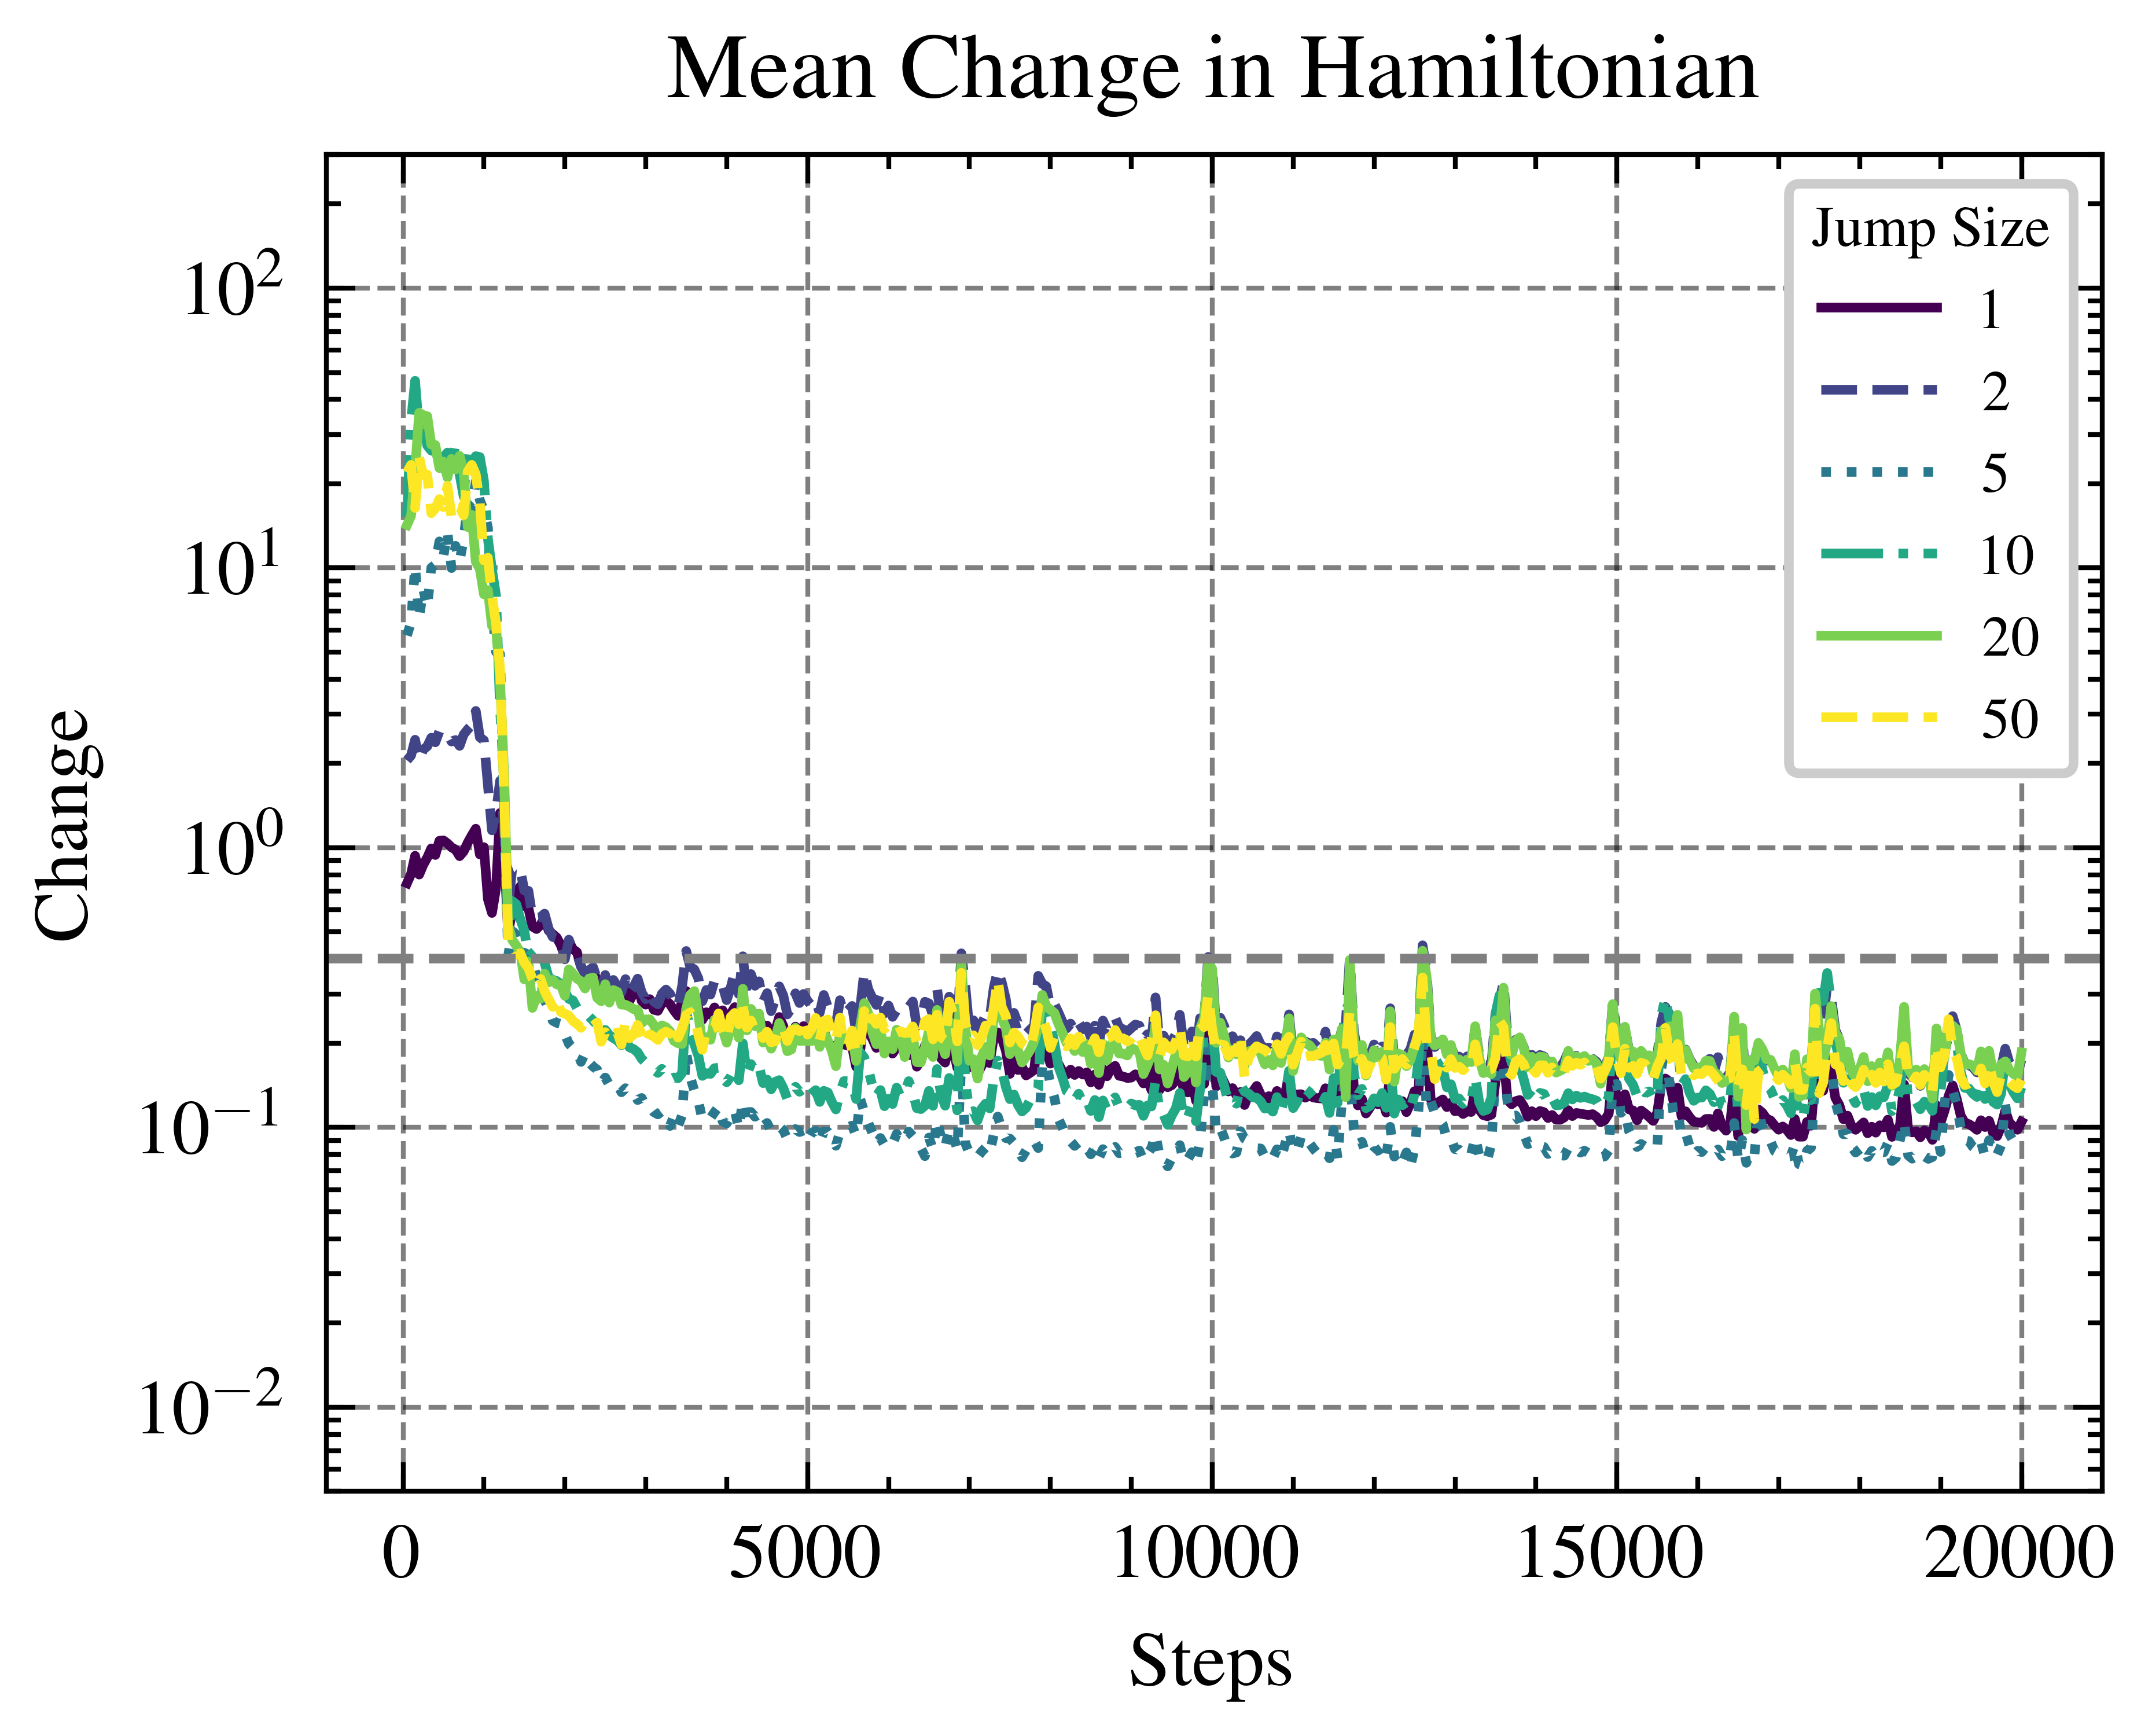

In [325]:
total_changes = {
    jump: np.asarray(
        list(all_test_metrics[step][jump]["mean_change_in_hamiltonians"] for step in all_test_metrics)
    )
    for jump in config.test_time_jumps
}
steps = list(all_test_metrics.keys())

true_position, true_momentum = train.inverse_transform_with_scaler(
    test_positions[:1], test_momentums[:1], scaler
)
actual_hamiltonian = harmonic_motion_simulation.compute_hamiltonian(
    true_position, true_momentum, test_simulation_parameters
)
actual_hamiltonian = np.asarray(actual_hamiltonian).squeeze()

with plt.style.context(PLT_STYLE_CONTEXT):
    fig, ax = plt.subplots()
    colors = plt.cm.viridis(np.linspace(0, 1, len(total_changes)))
    for jump_color, jump in zip(colors, config.test_time_jumps):
        total_changes_for_jump = total_changes[jump]
        ax.plot(steps, total_changes_for_jump, label=jump, color=jump_color)
    ax.axhline(y=actual_hamiltonian, c="gray", linestyle="--")
    ax.set_title("Mean Change in Hamiltonian")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Change")
    ax.set_yscale("log")
    ax.set_ylim(0.005, 300)
    ax.legend(title="Jump Size", loc="upper right", title_fontsize=6, fontsize=6)
    plt.show()
    
    fig.savefig(f"../notebook_outputs/paper/{config_name}/k_pair={k_pair}/change_in_hamiltonian.pdf", dpi=1000)

In [ ]:
with plt.style.context(PLT_STYLE_CONTEXT):
    # fig.savefig("../notebook_outputs/test_change_in_hamiltonian.pdf", dpi=1000)


### Plotting Loss



In [ ]:
with plt.style.context(PLT_STYLE_CONTEXT):
    total_losses = {
        jump: np.asarray(list(all_test_metrics[step][jump]["prediction_loss"] for step in all_test_metrics))
        for jump in config.test_time_jumps
    }
    steps = list(all_test_metrics.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(total_losses)))

    fig, ax = plt.subplots()
    for jump_color, jump in zip(colors, config.test_time_jumps):
        total_losses_for_jump = total_losses[jump]
        ax.plot(steps, total_losses_for_jump, label=jump, color=jump_color)

    ax.set_title("Time Jump Sizes: Test Loss")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Loss")
    ax.set_yscale("log")
    # ax.set_xscale("log")
    ax.legend(title="Jump Size")
    plt.show()

In [ ]:
fig.savefig("../notebook_outputs/test_losses.pdf", dpi=1000)

### Plotting Action and Angle Space

In [ ]:
# Sample position-momentum space.
max_position = 1.2 * np.abs(train_positions).max()
max_momentum = 1.2 * np.abs(train_momentums).max()
plot_positions = jnp.linspace(-max_position, max_position, num=100)
plot_momentums = jnp.linspace(-max_momentum, max_momentum, num=100)
grid = jnp.meshgrid(plot_positions, plot_momentums)
plot_positions = grid[0][:, :, jnp.newaxis]
plot_momentums = grid[1][:, :, jnp.newaxis]

# Pad the remaining coordinates with zeros.
def pad_coords(
    positions: chex.Array, momentums: chex.Array, index: int
) -> Tuple[chex.Array, chex.Array]:
    positions = jnp.pad(
        positions, ((0, 0), (0, 0), (index, config.num_trajectories - index - 1))
    )
    momentums = jnp.pad(
        momentums, ((0, 0), (0, 0), (index, config.num_trajectories - index - 1))
    )
    return positions, momentums


trajectory_index = 0
plot_positions, plot_momentums = pad_coords(
    plot_positions, plot_momentums, trajectory_index
)

# Compute actions and angles.
_, _, auxiliary_predictions = jax.vmap(state.apply_fn, in_axes=(None, 0, 0, None))(
    state.params, plot_positions, plot_momentums, 0
)
plot_actions = auxiliary_predictions["actions"]
plot_angles = auxiliary_predictions["current_angles"]

# Rescale back to original data range.
plot_positions, plot_momentums = jax.vmap(train.inverse_transform_with_scaler, in_axes=(0, 0, None))(
    plot_positions, plot_momentums, scaler
)
(
    train_positions_rescaled,
    train_momentums_rescaled,
) = train.inverse_transform_with_scaler(train_positions, train_momentums, scaler)
plot_positions, plot_momentums, plot_actions, plot_angles = jax.tree_map(
    lambda arr: arr[:, :, trajectory_index],
    (plot_positions, plot_momentums, plot_actions, plot_angles),
)

In [ ]:
fig, ax = plt.subplots()
contours = ax.contour(plot_positions, plot_momentums, plot_actions, 50, cmap="viridis")
fig.colorbar(contours)
ax.plot(
    train_positions_rescaled[:, trajectory_index],
    train_momentums_rescaled[:, trajectory_index],
    c="gray",
    linestyle="--",
)
ax.set_xlabel("q")
ax.set_ylabel("p")
ax.set_title("Actions Contour")
plt.show()

In [ ]:
fig.savefig("../notebook_outputs/actions_contour.pdf", dpi=1000)

In [ ]:
fig, ax = plt.subplots()
contours = ax.contour(plot_positions, plot_momentums, plot_angles, 50, cmap="viridis")
fig.colorbar(contours)
ax.plot(
    train_positions_rescaled[:, trajectory_index],
    train_momentums_rescaled[:, trajectory_index],
    c="gray",
    linestyle="--",
)
ax.set_xlabel("q")
ax.set_ylabel("p")
ax.set_title("Angles Contour")
plt.show()

In [ ]:
fig.savefig("../notebook_outputs/angles_contour.pdf", dpi=1000)

### Plotting True Trajectories

In [ ]:
(
    train_positions_rescaled,
    train_momentums_rescaled,
) = train.inverse_transform_with_scaler(train_positions, train_momentums, scaler)
max_position = np.abs(train_positions_rescaled).max()
max_momentum = np.abs(train_momentums_rescaled).max()

with plt.style.context(PLT_STYLE_CONTEXT):
    harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
        train_positions_rescaled,
        train_momentums_rescaled,
        title="Train Trajectories",
        max_position=max_position,
        max_momentum=max_momentum,
    )
    plt.show()

In [ ]:
train_true_trajectories_phase_space_anim = harmonic_motion_simulation.plot_coordinates_in_phase_space(
    train_positions_rescaled,
    train_momentums_rescaled,
    train_simulation_parameters,
    title="Train Trajectories",
    max_position=max_position,
    max_momentum=max_momentum,
)
train_true_trajectories_phase_space_anim

In [ ]:
train_true_trajectories_phase_space_anim.save(
    "../notebook_outputs/train_true_trajectories_phase_space.gif"
)

In [ ]:
test_positions_rescaled, test_momentums_rescaled = train.inverse_transform_with_scaler(
    test_positions, test_momentums, scaler
)
max_position = np.abs(train_positions_rescaled).max()
max_momentum = np.abs(train_momentums_rescaled).max()

with plt.style.context(PLT_STYLE_CONTEXT):
    harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
        test_positions_rescaled,
        test_momentums_rescaled,
        title="Test Trajectories",
        max_position=max_position,
        max_momentum=max_momentum,
    )
    plt.show()

In [ ]:
test_true_trajectories_phase_space_anim = harmonic_motion_simulation.plot_coordinates_in_phase_space(
    test_positions_rescaled[:200],
    test_momentums_rescaled[:200],
    test_simulation_parameters,
    title="TEST TRAJECTORIES",
    max_position=max_position,
    max_momentum=max_momentum,
)
test_true_trajectories_phase_space_anim

In [ ]:
test_true_trajectories_phase_space_anim.save(
        "../notebook_outputs/test_true_trajectories_phase_space.gif"
)

### One-Step Predictions

In [ ]:
def predict_for_trajectory(
    positions_for_trajectory: chex.Array,
    momentums_for_trajectory: chex.Array,
    jump: int,
) -> Tuple[chex.Array, chex.Array]:
    """Returns the preictions for the trajectory, in the original data scale."""

    (
        curr_positions,
        curr_momentums,
        target_positions,
        target_momentums,
    ) = train.get_coordinates_for_time_jump(
        positions_for_trajectory, momentums_for_trajectory, jump
    )
    (
        predicted_positions,
        predicted_momentums,
        auxiliary_predictions,
    ) = train.compute_predictions(
        state, curr_positions, curr_momentums, jump * config.time_delta
    )
    predicted_positions, predicted_momentums = train.inverse_transform_with_scaler(
        predicted_positions, predicted_momentums, scaler
    )
    return predicted_positions, predicted_momentums

In [ ]:
jump = 1
(
    train_positions_rescaled,
    train_momentums_rescaled,
) = train.inverse_transform_with_scaler(train_positions, train_momentums, scaler)
max_position = np.abs(train_positions_rescaled).max()
max_momentum = np.abs(train_momentums_rescaled).max()

predicted_positions, predicted_momentums = predict_for_trajectory(
    train_positions, train_momentums, jump
)
with plt.style.context(PLT_STYLE_CONTEXT):
    harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
        predicted_positions,
        predicted_momentums,
        title=f"Predicted Train Trajectories: Jump {jump}",
        max_position=max_position,
        max_momentum=max_momentum,
    )
    plt.show()

In [ ]:
train_one_step_predicted_trajectories_anim = (
    harmonic_motion_simulation.plot_coordinates(
        predicted_positions[:200],
        predicted_momentums[:200],
        train_simulation_parameters,
        title=f"ONE-STEP PREDICTED TRAIN TRAJECTORIES: JUMP {jump}",
    )
)
train_one_step_predicted_trajectories_anim

In [ ]:
jump = 10
(
    train_positions_rescaled,
    train_momentums_rescaled,
) = train.inverse_transform_with_scaler(train_positions, train_momentums, scaler)
max_position = np.abs(train_positions_rescaled).max()
max_momentum = np.abs(train_momentums_rescaled).max()

predicted_positions, predicted_momentums = predict_for_trajectory(
    test_positions, test_momentums, jump
)
with plt.style.context(PLT_STYLE_CONTEXT):
    harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
        predicted_positions,
        predicted_momentums,
        title=f"Predicted Test Trajectories: Jump {jump}",
        max_position=max_position,
        max_momentum=max_momentum,
    )
    plt.show()

In [ ]:
test_one_step_predicted_trajectories_anim = harmonic_motion_simulation.plot_coordinates(
    predicted_positions[:200],
    predicted_momentums[:200],
    test_simulation_parameters,
    title=f"One-Step Predicted Test Trajectories: Jump {jump}",
)
test_one_step_predicted_trajectories_anim

In [ ]:
test_one_step_predicted_trajectories_anim.save(
    "../notebook_outputs/test_one_step_predicted_trajectories.gif"
)

In [ ]:
test_one_step_predicted_trajectories_phase_space_anim = (
    harmonic_motion_simulation.plot_coordinates_in_phase_space(
        predicted_positions,
        predicted_momentums,
        test_simulation_parameters,
        title=f"One-Step Predicted Test Trajectories: Jump {Jump}",
    )
)
test_one_step_predicted_trajectories_phase_space_anim

In [ ]:
test_one_step_predicted_trajectories_phase_space_anim.save(
    "../notebook_outputs/test_one_step_predicted_trajectories_phase_space.gif"
)

### Model Performance as a Function of Time

In [ ]:
all_positions = jnp.concatenate((train_positions, test_positions), axis=0)
all_momentums = jnp.concatenate((train_momentums, test_momentums), axis=0)

assert np.all(jax.tree_leaves(jax.tree_map(jnp.allclose, train_simulation_parameters, test_simulation_parameters)))

In [ ]:
jump = 1
(
    _,
    _,
    target_positions,
    target_momentums,
) = train.get_coordinates_for_time_jump(
    all_positions, all_momentums, jump
)
predicted_positions, predicted_momentums = predict_for_trajectory(
    all_positions, all_momentums, jump
)
target_positions, target_momentums = train.inverse_transform_with_scaler(
    target_positions, target_momentums, scaler
)


In [ ]:
errors = jax.vmap(train.compute_loss)(predicted_positions, predicted_momentums, target_positions, target_momentums)
errors.mean()

In [ ]:
with plt.style.context(PLT_STYLE_CONTEXT):
    plt.plot(errors, c="teal")
    plt.grid(axis='x')
    plt.axvline(x=train_positions.shape[0], c="black", linestyle="--")
    plt.title("Prediction Error vs Time")
    plt.text(x=train_positions.shape[0] - 20, y=errors.max() * 1.1, fontsize=6, s="Train", horizontalalignment="right")
    plt.text(x=train_positions.shape[0] + 20, y=errors.max() * 1.1, fontsize=6, s="Test", horizontalalignment="left")
    plt.ylim((errors.min(), errors.max() * 1.2))
    plt.xlabel("Time")
    plt.ylabel("Prediction Error")
    plt.show()

In [ ]:
predicted_hamiltonians = jax.vmap(harmonic_motion_simulation.compute_hamiltonian, in_axes=(0, 0, None))(predicted_positions, predicted_momentums, train_simulation_parameters)
true_hamiltonians = jax.vmap(harmonic_motion_simulation.compute_hamiltonian, in_axes=(0, 0, None))(target_positions, target_momentums, train_simulation_parameters)
delta_hamiltonians = (predicted_hamiltonians - true_hamiltonians)
jnp.abs(delta_hamiltonians).mean()

In [ ]:
with plt.style.context(PLT_STYLE_CONTEXT):
    plt.plot(delta_hamiltonians, c="olivedrab")
    plt.grid(axis='x')
    plt.axvline(x=train_positions.shape[0], c="black", linestyle="--")
    plt.text(x=train_positions.shape[0] - 20, y=delta_hamiltonians.max() * 1.1, s="Train", horizontalalignment="right")
    plt.text(x=train_positions.shape[0] + 20, y=delta_hamiltonians.max() * 1.1, s="Test", horizontalalignment="left")
    plt.ylim((delta_hamiltonians.min(), delta_hamiltonians.max() * 1.2))
    plt.title("Change in Hamiltonian vs Time")
    plt.xlabel("Time")
    plt.ylabel("Change in Hamiltonian")
    plt.show()

### Distribution of Actions

In [ ]:
# Compute actions.
jump = 1
curr_positions, curr_momentums, *_ = train.get_coordinates_for_time_jump(
    train_positions, train_momentums, jump
)

_, _, auxiliary_predictions = state.apply_fn(
    state.params, curr_positions, curr_momentums, 0
)
plot_actions = auxiliary_predictions["actions"]
plot_angles = auxiliary_predictions["current_angles"]

actions = auxiliary_predictions["actions"]
for trajectory in range(actions.shape[1]):
    plt.hist(actions[:, trajectory], bins=50)
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.3f}"))
plt.show()

In [ ]:
true_angular_velocities = harmonic_motion_simulation.compute_normal_modes(train_simulation_parameters)[0]
true_angular_velocities

In [ ]:
angular_velocities = auxiliary_predictions["angular_velocities"]
for trajectory in range(angular_velocities.shape[1]):
    plt.hist(angular_velocities[:, trajectory], bins=50)
plt.xlabel("Angular Frequency")
plt.ylabel("Count")
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.4f}"))
plt.show()

### Non-Recursive Multi-Step Predictions

In [ ]:
jump = 1
non_recursive_predictions = state.apply_fn(
    state.params,
    test_positions[:1],
    test_momentums[:1],
    jnp.arange(1, 500) * jump * config.time_delta,
    method=models.ActionAngleNetwork.predict_multi_step,
)
(
    non_recursive_multi_step_predicted_positions,
    non_recursive_multi_step_predicted_momentums,
    non_recursive_multi_step_auxiliary_predictions,
) = non_recursive_predictions
non_recursive_multi_step_auxiliary_predictions[
    "angular_velocities"
], non_recursive_multi_step_auxiliary_predictions[
    "current_angles"
], non_recursive_multi_step_auxiliary_predictions[
    "future_angles"
][
    :10
]

In [ ]:
(
    non_recursive_multi_step_predicted_positions,
    non_recursive_multi_step_predicted_momentums,
) = train.inverse_transform_with_scaler(
    non_recursive_multi_step_predicted_positions,
    non_recursive_multi_step_predicted_momentums,
    scaler,
)

In [ ]:
with plt.style.context(PLT_STYLE_CONTEXT):
    harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
        non_recursive_multi_step_predicted_positions,
        non_recursive_multi_step_predicted_momentums,
        title=f"Predicted Test Trajectories: Jump {jump}",
    )
    plt.show()

In [ ]:
fig.savefig(
    f"../notebook_outputs/test_multi_step_predicted_phase_space_jump_{jump}.pdf",
    dpi=1000,
    bbox_inches="tight",
    pad_inches=0,
)

In [ ]:
test_multi_step_predicted_trajectories_anim = harmonic_motion_simulation.plot_coordinates(
    non_recursive_multi_step_predicted_positions,
    non_recursive_multi_step_predicted_momentums,
    test_simulation_parameters,
    title="NON-RECURSIVE MULTI-STEP PREDICTED TEST TRAJECTORIES",
)
test_multi_step_predicted_trajectories_anim

In [ ]:
test_multi_step_predicted_trajectories_anim.save(
    "../notebook_outputs/test_non_recursive_multi_step_predicted_trajectories.gif"
)

In [ ]:
test_multi_step_predicted_trajectories_phase_space_anim = (
    harmonic_motion_simulation.plot_coordinates_in_phase_space(
        non_recursive_multi_step_predicted_positions[:1000],
        non_recursive_multi_step_predicted_momentums[:1000],
        test_simulation_parameters,
        title=f"Predicted Test Trajectories: Jump {jump}",
    )
)
test_multi_step_predicted_trajectories_phase_space_anim

In [ ]:
test_multi_step_predicted_trajectories_phase_space_anim.save(
    f"../notebook_outputs/test_non_recursive_multi_step_predicted_trajectories_phase_space_jump_{jump}.gif"
)

### Recursive Multi-Step Predictions

In [ ]:
def predict_next_step(carry, _):
    current_position, current_momentum = carry
    (
        predicted_position,
        predicted_momentum,
        auxiliary_predictions,
    ) = train.compute_predictions(
        state, current_position, current_momentum, config.time_delta
    )
    return (predicted_position, predicted_momentum), (
        predicted_position,
        predicted_momentum,
        auxiliary_predictions,
    )


_, recursive_predictions = jax.lax.scan(
    predict_next_step, (test_positions[0, :1], test_momentums[0, :1]), None, length=1000
)
(
    recursive_multi_step_predicted_positions,
    recursive_multi_step_predicted_momentums,
    recursive_multi_step_auxiliary_predictions,
) = recursive_predictions
recursive_multi_step_auxiliary_predictions["angular_velocities"][
    0
], recursive_multi_step_auxiliary_predictions["current_angles"][
    :10
], recursive_multi_step_auxiliary_predictions[
    "future_angles"
][
    :10
]

In [ ]:
recursive_multi_step_predicted_positions[0], recursive_multi_step_predicted_momentums[0]

In [ ]:
(
    recursive_multi_step_predicted_positions,
    recursive_multi_step_predicted_momentums,
) = train.inverse_transform_with_scaler(
    recursive_multi_step_predicted_positions,
    recursive_multi_step_predicted_momentums,
    scaler,
)

In [ ]:
recursive_multi_step_predicted_positions[0], recursive_multi_step_predicted_momentums[0]

In [ ]:
test_multi_step_predicted_trajectories_anim = (
    harmonic_motion_simulation.plot_coordinates(
        recursive_multi_step_predicted_positions[:200],
        recursive_multi_step_predicted_momentums[:200],
        test_simulation_parameters,
        title="RECURSIVE MULTI-STEP PREDICTED TEST TRAJECTORIES",
    )
)
test_multi_step_predicted_trajectories_anim

In [ ]:
test_multi_step_predicted_trajectories_anim.save(
    "../notebook_outputs/test_recursive_multi_step_predicted_trajectories.gif"
)

In [ ]:
harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
    recursive_multi_step_predicted_positions,
    recursive_multi_step_predicted_momentums,
    title="RECURSIVE MULTI-STEP PREDICTED TEST TRAJECTORIES",
)

In [ ]:
test_multi_step_predicted_trajectories_phase_space_anim = (
    harmonic_motion_simulation.plot_coordinates_in_phase_space(
        recursive_multi_step_predicted_positions[:200],
        recursive_multi_step_predicted_momentums[:200],
        test_simulation_parameters,
        title="RECURSIVE MULTI-STEP PREDICTED TEST TRAJECTORIES",
    )
)
test_multi_step_predicted_trajectories_phase_space_anim

In [ ]:
test_multi_step_predicted_trajectories_phase_space_anim.save(
    "../notebook_outputs/test_recursive_multi_step_predicted_trajectories_phase_space.gif"
)